
<h1><center>  Étude de la fréquence des sinistres matériels
 </center></h1>

Dans ce notebook, nous avons développé divers modèles d'apprentissage automatique pour prédire la fréquence des sinistres matériels.

In [11]:
# Librairies :
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 


In [6]:
# Import des données :
df =  pd.read_csv("training_clean.csv")
df.head()

,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,85,3,15080.0,0,L46,L,72.012883,365.0,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370.0,1,O38,O,39.550411,365.0,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,85,0,39650.0,0,Q28,Q,169.529148,365.0,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600.0,1,L6,L,58.894688,365.0,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065.0,0,N4,N,109.631885,365.0,2,0,0.0,0.0


# 2 - Retraitement des données : <a class="anchor" id="retraitements"></a>

In [7]:
# Suppression des données erronées :
df= df.iloc[21:]

In [8]:
df.columns

Index(['PolNum', 'CalYear', 'Gender', 'Type', 'Category', 'Occupation', 'Age',
       'Group1', 'Bonus', 'Poldur', 'Value', 'Adind', 'SubGroup2', 'Group2',
       'Density', 'Exppdays', 'Numtppd', 'Numtpbi', 'Indtppd', 'Indtpbi'],
      dtype='object')

In [9]:
bins = [18, 25, 40, 60, 100]  # Adaptez ces valeurs selon vos observations spécifiques
labels = ['18-24', '25-39', '40-59', '60+']  # Les labels correspondent aux tranches d'âge

# Utilisez pd.cut pour binariser la colonne 'Age'
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Age_Bonus'] = df['Age'] * df['Bonus']

# Vérifiez le résultat
df[['Age', 'AgeGroup']].head()
# Groupez par 'AgeGroup' et puis appliquez 'value_counts' sur 'Numtpbi'
grouped_counts = df.groupby('AgeGroup')['Numtppd'].value_counts().unstack(fill_value=0)

# Affichez le résultat
print(grouped_counts)

Numtppd       0     1    2    3   4  5  6  7
AgeGroup                                    
18-24      9989  2491  558  136  26  2  6  3
25-39     31339  4194  595  119  30  9  2  3
40-59     34535  3017  308   48   6  6  1  1
60+       11849   630   52    3   0  0  0  0


/tmp/ipykernel_2091/3574008947.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = df.groupby('AgeGroup')['Numtppd'].value_counts().unstack(fill_value=0)


In [12]:
numeric_features = ['Age_Bonus', 'Poldur', 'Indtppd']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['Gender', 'Occupation']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [14]:
# Split the data into features and target variable
X = df[['Gender', 'Occupation', 'Age_Bonus', 'Poldur','Indtppd']]
y = df['Numtppd']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, Indtppd_train, Indtppd_test = train_test_split(X, y, df['Indtppd'], test_size=0.2, random_state=42)


# 2- Modèles

## Regression

In [15]:
# Define the regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")




Mean Squared Error: 0.08779002162899098
R^2 Score: 0.5438720768484129


## Random Forest

In [16]:

# Define the regression model pipeline with a random forest regressor
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])


model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf


(0.02847799119647859, 0.8520377744651404)

In [17]:

model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])
param_grid_rf = {
    'regressor__n_estimators': [10, 50, 100],  # Nombre d'arbres
    'regressor__max_depth': [None, 10, 20],  # Profondeur maximale des arbres
    'regressor__min_samples_split': [2, 4],  # Nombre minimal d'échantillons requis pour diviser un nœud interne
    'regressor__min_samples_leaf': [1, 2]  # Nombre minimal d'échantillons requis pour être au niveau d'un nœud feuille
}

# Configuration et exécution de la recherche sur grille
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
# Affichage des meilleurs paramètres et du meilleur score R²
print("Meilleurs paramètres trouvés pour la forêt aléatoire:", grid_search_rf.best_params_)
print("Meilleur score R² pour la forêt aléatoire:", grid_search_rf.best_score_)

Meilleurs paramètres trouvés pour la forêt aléatoire: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Meilleur score R² pour la forêt aléatoire: 0.8609337389761401


## XGBOOST

In [18]:
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__max_depth': [3, 6, 9],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1, verbose=0)
grid_search_xgb.fit(X_train, y_train)

best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

#print("Meilleurs paramètres trouvés :", grid_search_xgb.best_params_)
print("Meilleur score R² :", grid_search_xgb.best_score_)

Meilleur score R² : 0.8602576339597064


Le meilleur modèle pour prédire votre variable cible est le modèle Random Forest, qui a obtenu un score R² de 0.86. 

## Appréciation des resultats

In [19]:
dataProv = pd.DataFrame(X_test.index)
dataProv.columns = ['index']

dataProv['Obs'] = y_test.reset_index(drop=True)
#dataProv['Pred_svm'] = y_pred_svm   
dataProv['Pred_rf'] = y_pred_rf.astype(int)
dataProv['Pred_xgb'] = y_pred_xgb.astype(int)

dataProv.head()

,index,Obs,Pred_rf,Pred_xgb
0,38916,0,0,0
1,599,1,1,1
2,83171,0,0,0
3,27500,0,0,0
4,48832,0,0,0


In [21]:
dataFinale = df.copy().reset_index().merge(dataProv)
dataFinale.head()

,index,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,...,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,AgeGroup,Age_Bonus,Obs,Pred_rf,Pred_xgb
0,29,200114879,2009,Male,C,Small,Self-employed,43,7,-50,...,302.5,0,0,0.000000,0.0,40-59,-2150,0,0,0
1,44,200114894,2009,Male,A,Small,Self-employed,47,17,20,...,365.0,1,0,867.683098,0.0,40-59,940,1,1,1
2,60,200114910,2009,Female,A,Medium,Housewife,46,7,-50,...,365.0,1,0,406.547234,0.0,40-59,-2300,1,1,1
3,74,200114924,2009,Male,B,Large,Retired,66,16,-50,...,365.0,0,0,0.000000,0.0,60+,-3300,0,0,0
4,91,200114941,2009,Female,B,Medium,Unemployed,43,9,-10,...,302.5,0,0,0.000000,0.0,40-59,-430,0,0,0


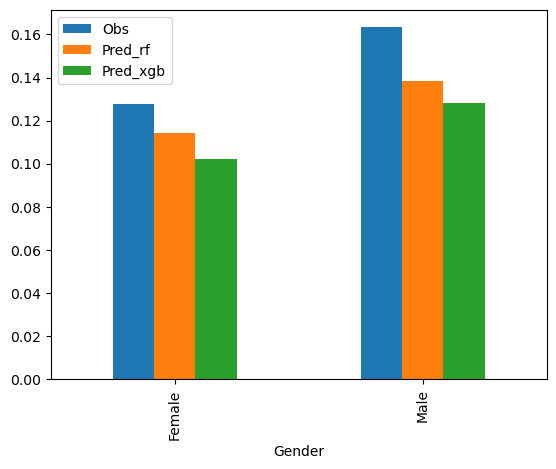

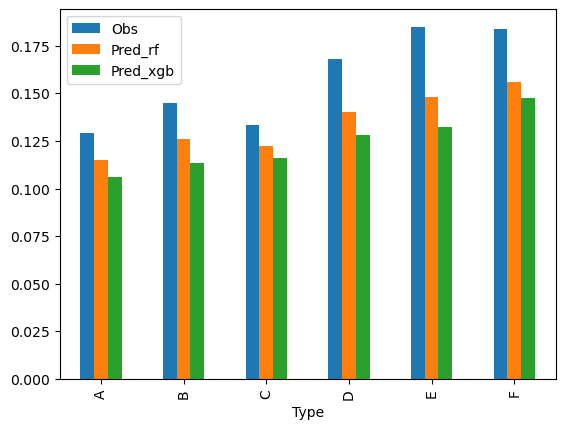

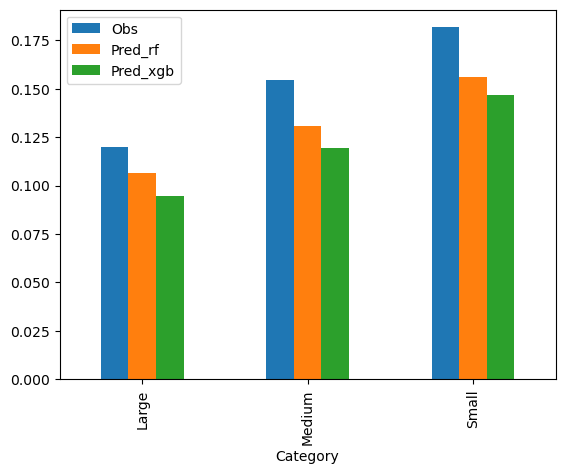

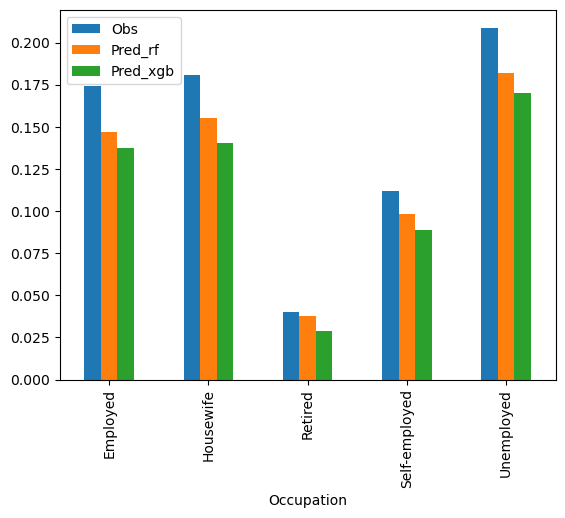

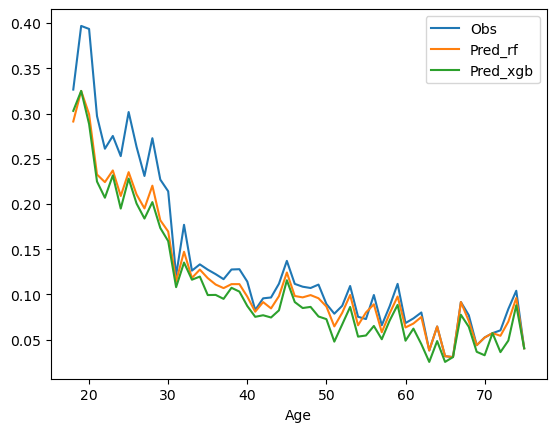

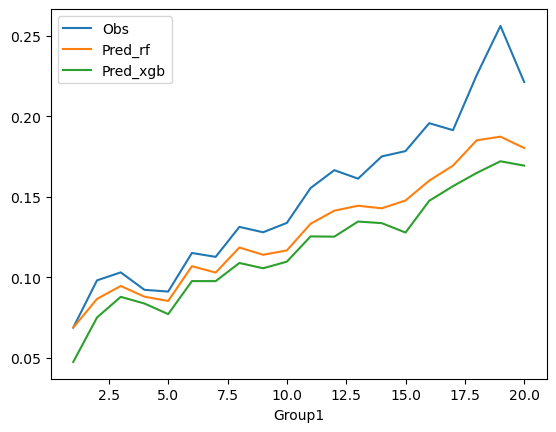

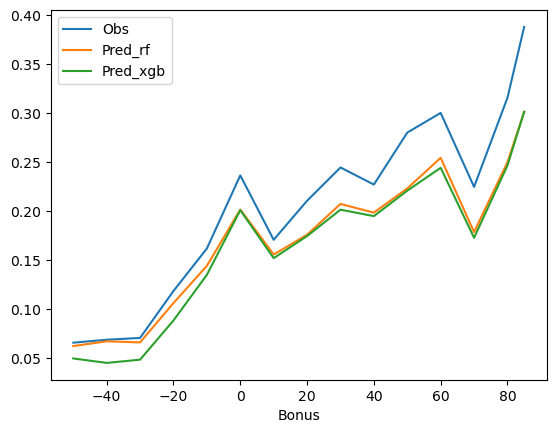

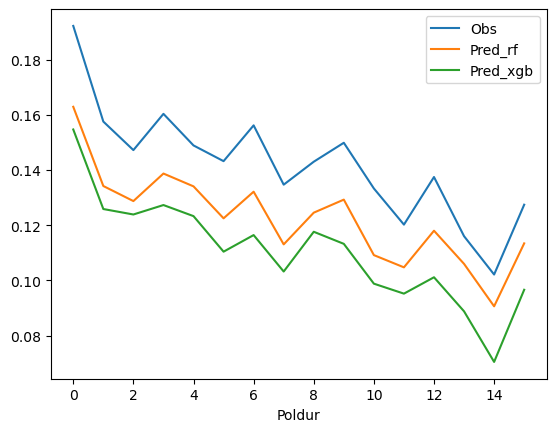

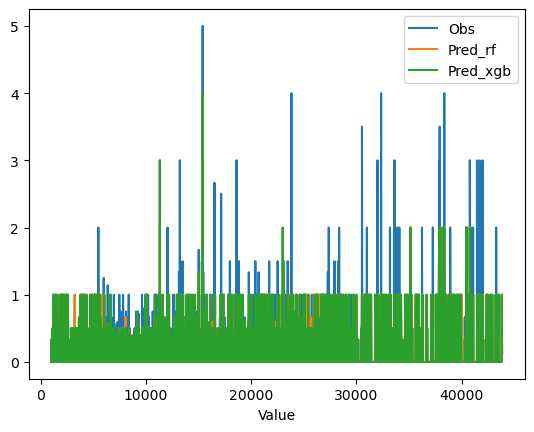

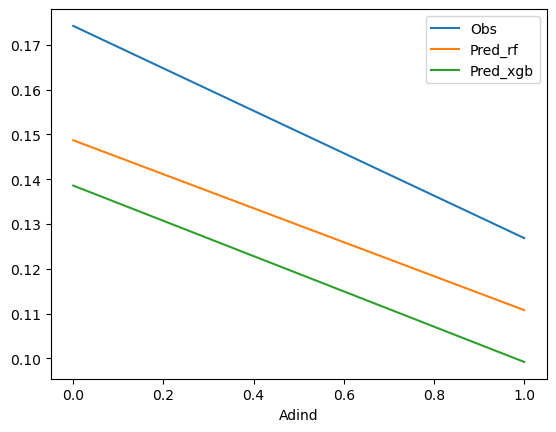

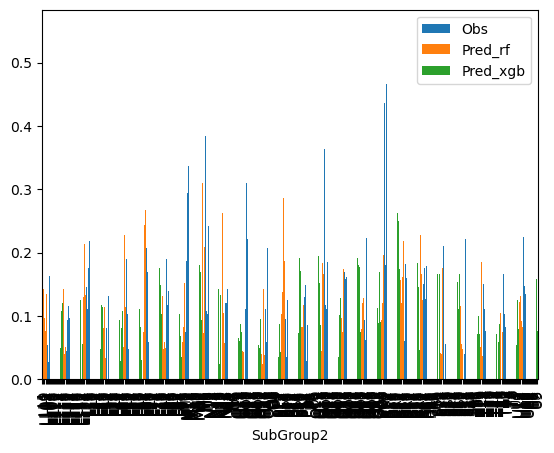

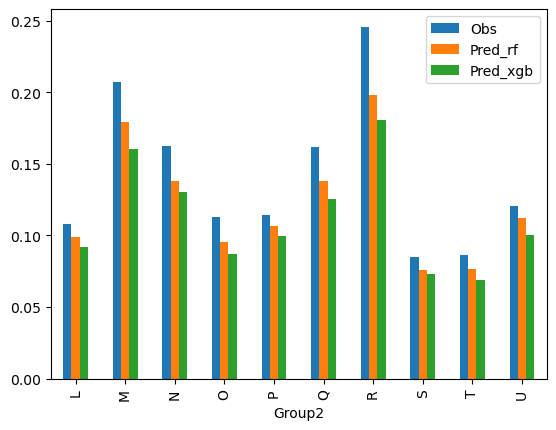

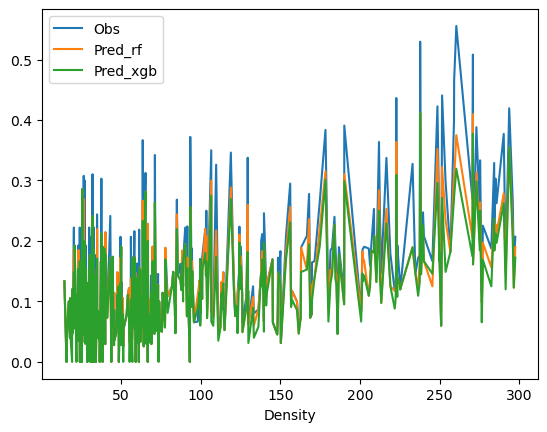

In [22]:
for var in dataFinale.columns[3:16]:
#     dataFinale.groupby([var])[['Obs', 'Pred_model', 'Pred_knn', 'Pred_tree', 'Pred_xgb']].mean().plot()
    dataPlot = dataFinale.groupby([var])[['Obs','Pred_rf', 'Pred_xgb']].mean()
        
    if dataFinale[var].dtypes == 'O':
        dataPlot.plot(kind='bar')
    else:
        dataPlot.plot()

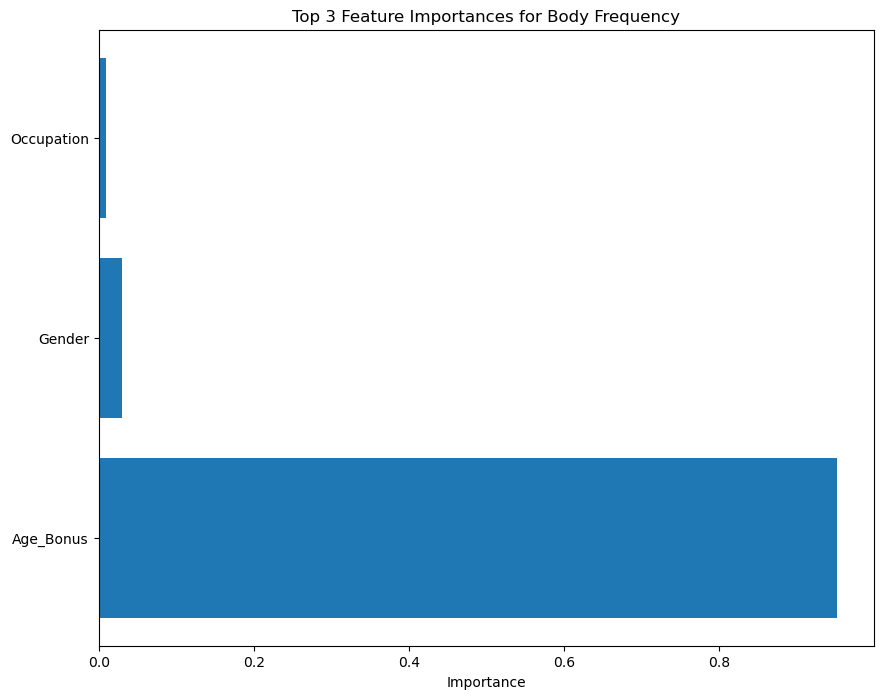

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Supposer que grid_search_rf est votre GridSearchCV avec un RandomForest comme estimateur dans une pipeline
best_rf_model = grid_search_rf.best_estimator_

# Accéder au RandomForestRegressor à l'intérieur de la pipeline
# L'étape du modèle est nommée 'regressor' ici, ajustez si nécessaire
random_forest_model = best_rf_model.named_steps['regressor']
feature_importances = random_forest_model.feature_importances_

# Assurez-vous que la liste des noms des caractéristiques correspond à ce que vous attendez
feature_names = ['Gender', 'Occupation', 'Age_Bonus', 'Poldur','Indtpbi', 'Type']  # Ajustez selon vos données

# Trier les caractéristiques par leur importance
sorted_idx = np.argsort(feature_importances)

# Sélectionner les 5 caractéristiques les plus importantes
top_5_idx = sorted_idx[-3:]

# Créer le graphique
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_5_idx)), feature_importances[top_5_idx], align='center')
plt.yticks(range(len(top_5_idx)), np.array(feature_names)[top_5_idx])
plt.xlabel('Importance')
plt.title("Top 3 Feature Importances for Body Frequency")
plt.gca().invert_yaxis()
plt.show()
 

# 3- Prime

In [24]:
# Calcul de la prime réelle
prime_reelle = y_test * Indtppd_test

# Calcul de la prime prédite (en assumant que y_pred_rf est déjà arrondi aux entiers si nécessaire)
prime_predite = y_pred_rf * Indtppd_test

# Vous pouvez maintenant comparer prime_reelle et prime_predite, par exemple, en calculant l'erreur quadratique moyenne ou toute autre métrique pertinente.
mse_prime = mean_squared_error(prime_reelle, prime_predite)
print(f"MSE pour la prime : {mse_prime}")

MSE pour la prime : 178621.92182154022


In [25]:
y_pred_rf = np.array(y_pred_rf)

# Calcul de la prime réelle et de la prime prédite
prime_reelle = y_test * Indtppd_test
prime_predite = y_pred_rf * Indtppd_test

# Création d'un DataFrame avec les primes réelles et prédites
df_primes = pd.DataFrame({
    'Prime_Reelle': prime_reelle,
    'Prime_Predite': prime_predite
})

# Affichage du DataFrame
df_primes.head(50)

,Prime_Reelle,Prime_Predite
38916,0.000000,0.000000
599,583.350978,692.686718
83171,0.000000,0.000000
27500,0.000000,0.000000
48832,0.000000,0.000000
11334,0.000000,0.000000
28467,0.000000,0.000000
68267,0.000000,0.000000
83717,0.000000,0.000000
16282,0.000000,0.000000


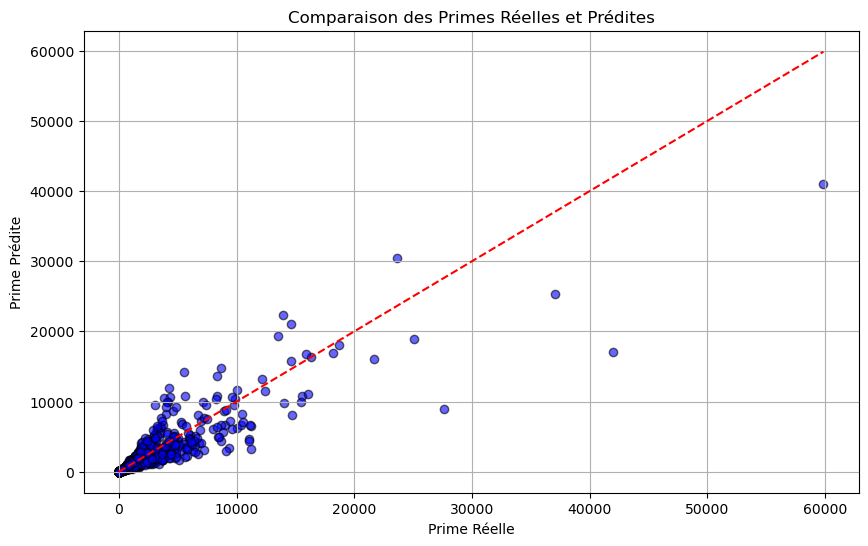

In [26]:
import matplotlib.pyplot as plt

# Création du graphique de dispersion
plt.figure(figsize=(10, 6))

# Tracer les primes réelles par rapport aux primes prédites
plt.scatter(df_primes['Prime_Reelle'], df_primes['Prime_Predite'], color='blue', alpha=0.6, edgecolors='black')

# Tracer la ligne de parfaite prédiction
max_prime = max(df_primes['Prime_Reelle'].max(), df_primes['Prime_Predite'].max())
plt.plot([0, max_prime], [0, max_prime], 'r--')

# Ajout de légendes et de titres
plt.xlabel('Prime Réelle')
plt.ylabel('Prime Prédite')
plt.title('Comparaison des Primes Réelles et Prédites')
plt.grid(True)

plt.show()

